In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
plt.style.use('ggplot')

In [2]:
train = pd.read_csv('train.csv')
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
train["year"] = pd.to_datetime(train["date"]).dt.year
train["month"] = pd.to_datetime(train["date"]).dt.month
train["month_year"] = pd.to_datetime(train["date"]).dt.to_period('M')
train.shape

(913000, 7)

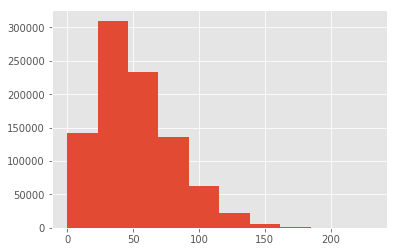

In [4]:
plt.hist(train["sales"])
plt.show()

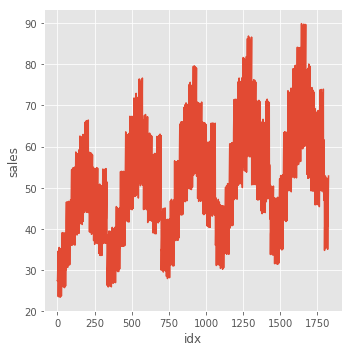

In [5]:
mean_sales = train.groupby(["date"], as_index=False)
mean_sales = mean_sales[["sales"]].mean()
mean_sales["idx"] = mean_sales.index
g = sns.relplot(x="idx", y="sales", data=mean_sales, kind="line")

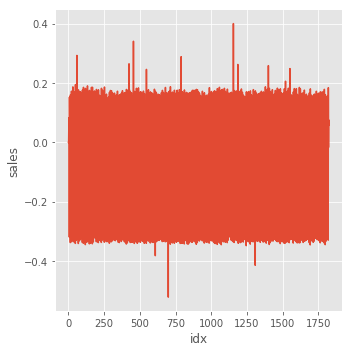

In [6]:
rt = pd.Series(mean_sales["sales"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="sales", x="idx", data=rt, kind="line")

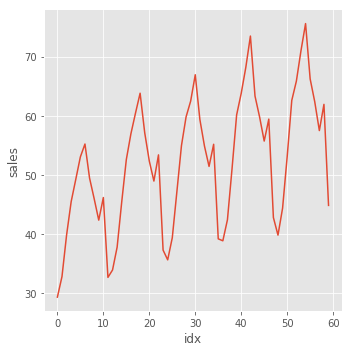

In [7]:
mean_sales_monthly = train.groupby(["month_year"], as_index=False)
mean_sales_monthly = mean_sales_monthly[["sales"]].mean()
mean_sales_monthly["idx"] = mean_sales_monthly.index
g = sns.relplot(y="sales", x="idx", data=mean_sales_monthly, kind="line")

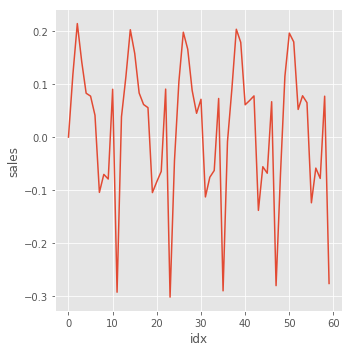

In [8]:
rt = pd.Series(mean_sales_monthly["sales"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="sales", x="idx", data=rt, kind="line")

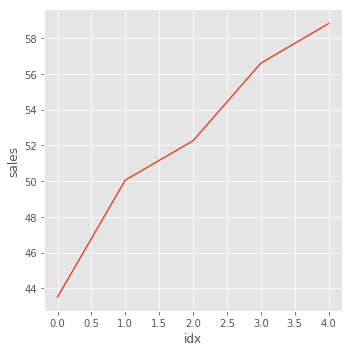

In [9]:
mean_sales_yearly = train.groupby(["year"], as_index=False)
mean_sales_yearly = mean_sales_yearly[["sales"]].mean()
mean_sales_yearly["idx"] = mean_sales_yearly.index
g = sns.relplot(y="sales", x="idx", data=mean_sales_yearly, kind="line")

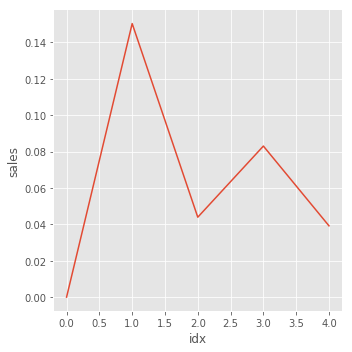

In [10]:
rt = pd.Series(mean_sales_yearly["sales"]).pct_change()
rt = pd.DataFrame(rt)
rt["idx"] = rt.index
rt.fillna(0, inplace=True)
g = sns.relplot(y="sales", x="idx", data=rt, kind="line")

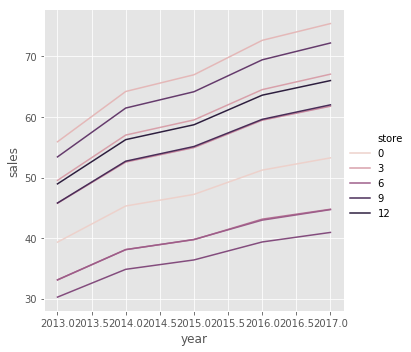

In [11]:
data = train.groupby(['store',"year"])
mean = data[["sales"]].mean()
mean = mean.add_suffix('').reset_index()
g = sns.relplot(y="sales", x="year", data=mean, kind="line", hue="store")

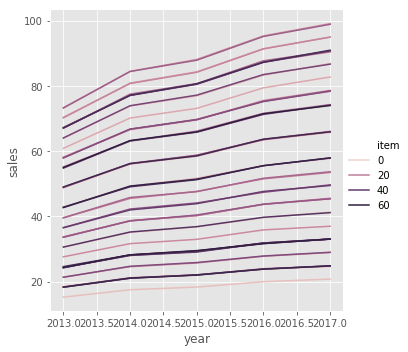

In [12]:
data = train.groupby(['item',"year"])
mean = data[["sales"]].mean()
mean = mean.add_suffix('').reset_index()
g = sns.relplot(y="sales", x="year", data=mean, kind="line", hue="item")

In [13]:
s1i1 = train[(train["store"]==1) & (train["item"])==1]
s1i1["sales"] = np.log1p(s1i1["sales"])
s1i1.head()

/home/roxai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,store,item,sales,year,month,month_year
0,2013-01-01,1,1,2.639057,2013,1,2013-01
1,2013-01-02,1,1,2.484907,2013,1,2013-01
2,2013-01-03,1,1,2.708050,2013,1,2013-01
3,2013-01-04,1,1,2.639057,2013,1,2013-01
4,2013-01-05,1,1,2.397895,2013,1,2013-01


In [14]:
stats = s1i1[["date", "sales"]]
stats.columns = ["ds", "y"]
stats.head()

,ds,y
0,2013-01-01,2.639057
1,2013-01-02,2.484907
2,2013-01-03,2.708050
3,2013-01-04,2.639057
4,2013-01-05,2.397895


In [54]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False,changepoint_prior_scale=0.05)
m.add_seasonality(period=30.4, name='monthly', fourier_order=12)
m.add_seasonality(name='weekly',period=7,fourier_order=15)
m.add_seasonality(name='daily',period=1,fourier_order=20)
m.fit(stats)
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
46010,2018-12-27
46011,2018-12-28
46012,2018-12-29
46013,2018-12-30
46014,2018-12-31


In [55]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
46010,2018-12-27,3.533332,2.902285,4.161082
46011,2018-12-28,3.610555,2.940995,4.229516
46012,2018-12-29,3.674167,3.027258,4.301394
46013,2018-12-30,3.724143,3.102439,4.384974
46014,2018-12-31,3.324424,2.618898,3.976077


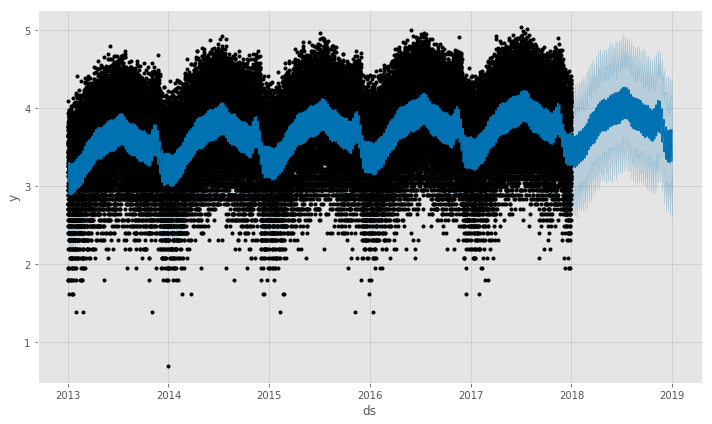

In [56]:
fig1 = m.plot(forecast)

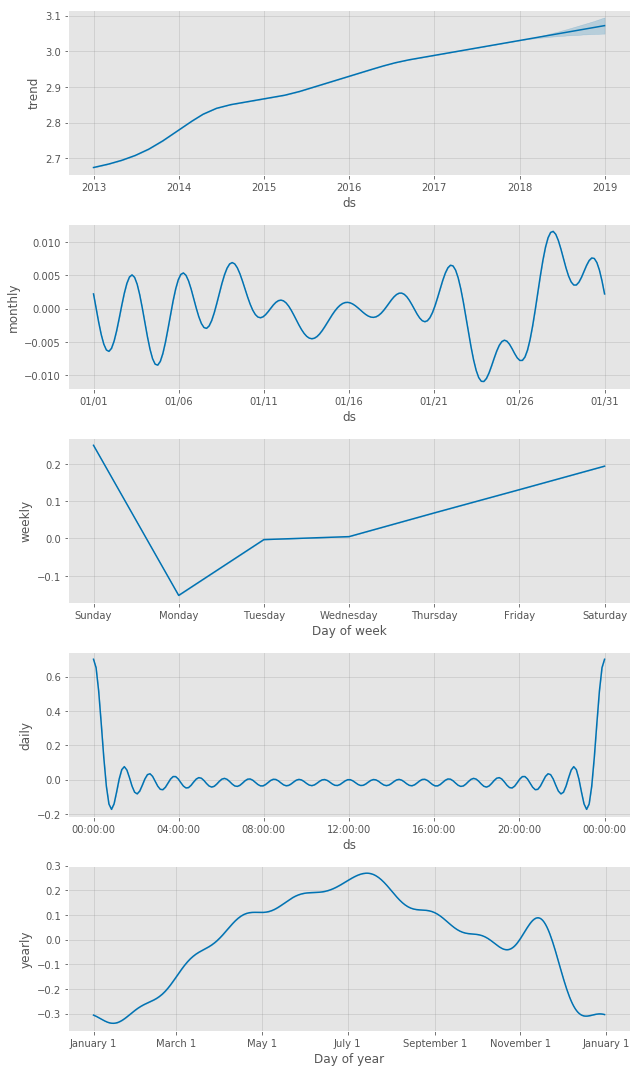

In [57]:
fig2 = m.plot_components(forecast)

In [60]:
m.changepoints

1461    2013-02-28
2922    2013-04-27
4382    2013-06-25
5843    2013-08-22
7304    2013-10-20
8765    2013-12-17
10225   2014-02-14
11686   2014-04-13
13147   2014-06-10
14608   2014-08-08
16068   2014-10-05
17529   2014-12-03
18990   2015-01-30
20451   2015-03-30
21911   2015-05-27
23372   2015-07-24
24833   2015-09-21
26294   2015-11-18
27754   2016-01-16
29215   2016-03-14
30676   2016-05-12
32137   2016-07-09
33597   2016-09-05
35058   2016-11-03
36519   2016-12-31
Name: ds, dtype: datetime64[ns]

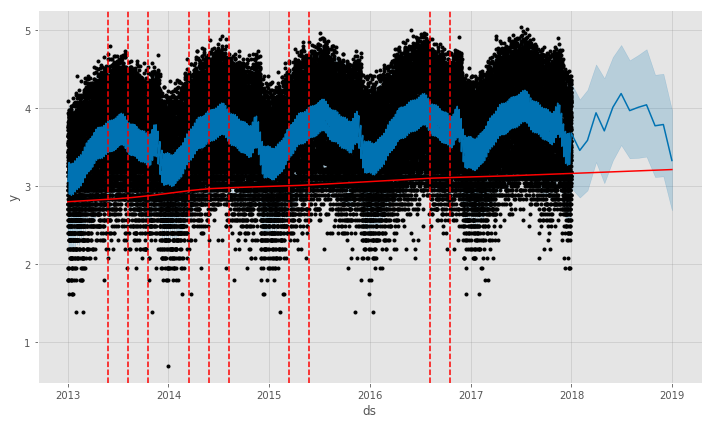

In [47]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

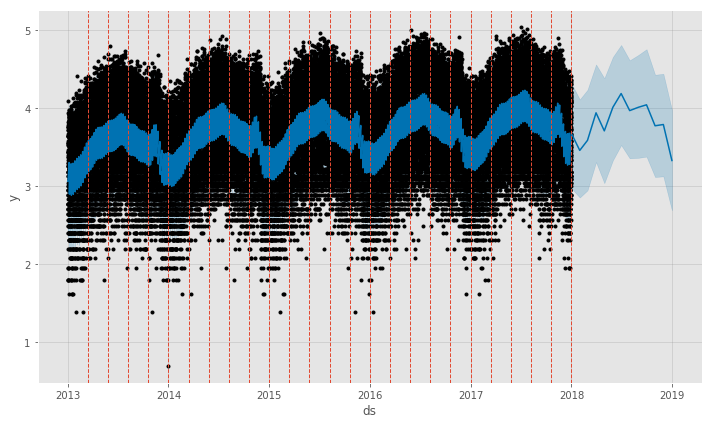

In [48]:
figure = m.plot(forecast)
for changepoint in m.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)

In [42]:
if 'weekly' in m.seasonalities and 'weekly' in forecast:
        print('True')

True


In [151]:
from pandas import DataFrame
trend = pd.DataFrame(data = forecast.trend)

In [154]:
trend.tail()

,trend
46010,4.658820
46011,4.662769
46012,4.666991
46013,4.671077
46014,4.675299


In [62]:
from pandas import DataFrame
# yearly = pd.DataFrame(data = forecast.yearly.tail(365))
yearly = forecast.yearly.tail(365)

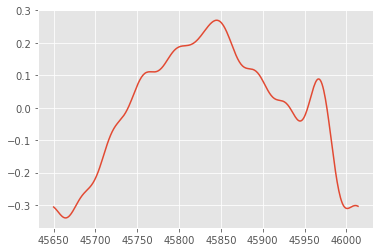

In [65]:
plt.plot(yearly)

In [143]:
from pandas import DataFrame
weekly = pd.DataFrame(data = forecast)

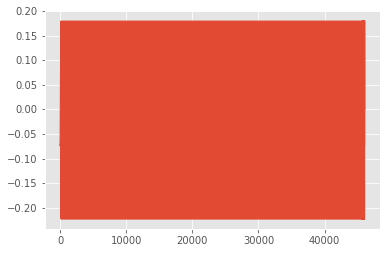

In [144]:
plt.plot(weekly)

In [34]:
from pandas import DataFrame
monthly = pd.DataFrame(data = forecast.monthly.tail(30))

,monthly
46000,-0.000069
46001,0.000874
46002,0.000131
46003,-0.000590
46004,0.001283
46005,0.003304
46006,0.000719
46007,-0.005557
46008,-0.009548
46009,-0.007871


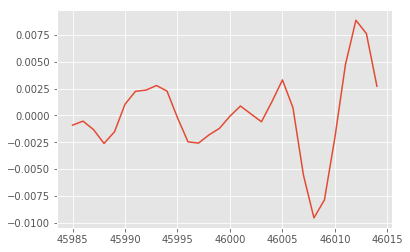

In [37]:
plt.plot(monthly)
monthly.tail(15)

,weekly
46008,-0.072728
46009,-0.065069
46010,-0.001803
46011,0.060277
46012,0.123011
46013,0.178727
46014,-0.222414


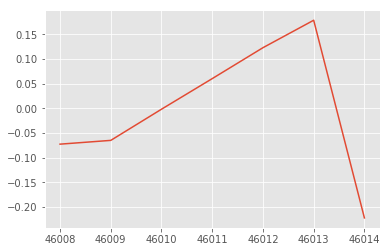

In [46]:
from pandas import DataFrame
weekly = pd.DataFrame(data = forecast.weekly.tail(7))
plt.plot(weekly)
weekly.tail(7)

,daily
46008,0.378731
46009,0.378731
46010,0.378731
46011,0.378731
46012,0.378731
46013,0.378731
46014,0.378731


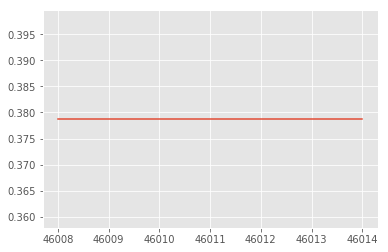

In [53]:
from pandas import DataFrame
daily = pd.DataFrame(data = forecast.daily.tail(7))
plt.plot(daily)
daily.tail(7)

/home/roxai/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:1444: DeprecationWarning: This method will be removed in the next version. Please use fbprophet.plot.plot_weekly. 
  DeprecationWarning,


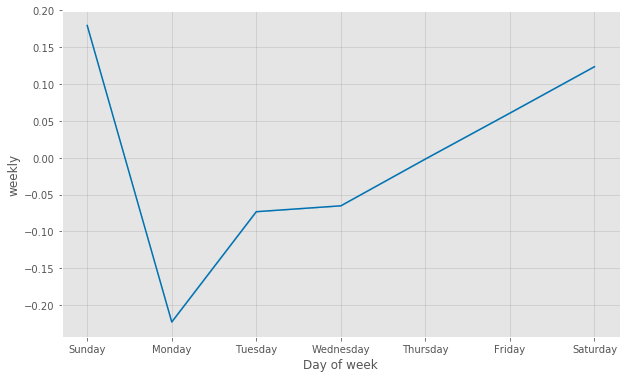

In [23]:
one = 

/home/roxai/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:1454: DeprecationWarning: This method will be removed in the next version. Please use fbprophet.plot.plot_yearly. 
  DeprecationWarning,


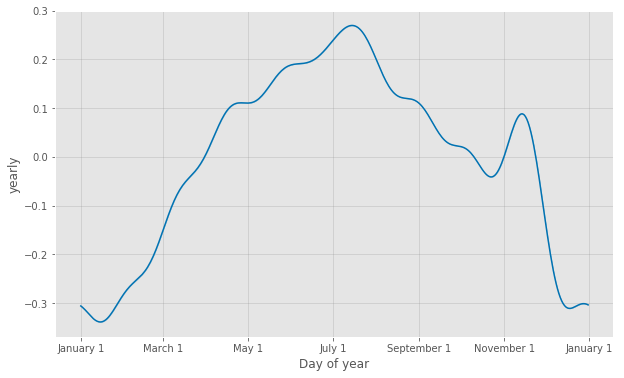

In [24]:
two = m.plot_yearly(uncertainty=True, yearly_start=0)